In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Bone/')]
groups = ['Histone', 'TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Bone/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/144 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("bone.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 5000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
win_in[:10]

[['chr1', 42723900, 42728900],
 ['chr1', 165593917, 165598917],
 ['chr1', 235014974, 235019974],
 ['chr1', 165593919, 165598919],
 ['chr1', 143284032, 143289032],
 ['chr1', 162181950, 162186950],
 ['chr1', 45766466, 45771466],
 ['chr1', 37964610, 37969610],
 ['chr1', 174639171, 174644171],
 ['chr1', 120130885, 120135885]]

In [7]:
win_out[:10]

[['chr1', 42623900, 42628900],
 ['chr1', 42573900, 42578900],
 ['chr1', 42548900, 42553900],
 ['chr1', 42573900, 42578900],
 ['chr1', 42623900, 42628900],
 ['chr1', 42723900, 42728900],
 ['chr1', 165493917, 165498917],
 ['chr1', 165443917, 165448917],
 ['chr1', 165418917, 165423917],
 ['chr1', 165443917, 165448917]]

In [8]:
print(len(win_in), len(win_out))

2424 14517


In [9]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]


In [10]:
print(len(ints_in1), len(ints_out1))

2424 4848


In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr3', '142188791', '142193791', '0'],
       ['chr22', '26863103', '26868103', '0'],
       ['chrX', '116567368', '116572368', '0'],
       ['chr6', '56605313', '56610313', '1'],
       ['chr22', '36658216', '36663216', '1'],
       ['chr1', '1006334', '1011334', '0'],
       ['chr17', '50031658', '50036658', '0'],
       ['chr11', '29697288', '29702288', '0'],
       ['chr7', '88769610', '88774610', '1'],
       ['chr9', '109371066', '109376066', '0']], dtype='<U21')

In [12]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []


pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row) 
        y.append(target) 
    else:
        continue 

pbar.close()

100%|████████████████| 7272/7272 [00:24<00:00, 293.37it/s]


In [13]:
X = np.array(X)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239,  1.5890359 ],
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       ...,
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       [-0.15142034, -0.03438813, -0.06282409, ...,  0.07037941,
        -0.02613239,  0.8856075 ]], dtype=float32)

In [15]:
X.shape

(7272, 144)

In [16]:
y

tensor([0, 0, 0,  ..., 0, 1, 0])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-14 20:38:44.410392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 20:38:45.109242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
182/182 [==============================] - 2s 10ms/step - loss: 0.6417 - accuracy: 0.6663 - val_loss: 0.6352 - val_accuracy: 0.6680
Epoch 2/10
182/182 [==============================] - 2s 8ms/step - loss: 0.6396 - accuracy: 0.6663 - val_loss: 0.6361 - val_accuracy: 0.6680
Epoch 3/10
182/182 [==============================] - 1s 8ms/step - loss: 0.6370 - accuracy: 0.6663 - val_loss: 0.6354 - val_accuracy: 0.6680
Epoch 4/10
182/182 [==============================] - 1s 8ms/step - loss: 0.6363 - accuracy: 0.6663 - val_loss: 0.6365 - val_accuracy: 0.6680
Epoch 5/10
182/182 [==============================] - 1s 8ms/step - loss: 0.6363 - accuracy: 0.6663 - val_loss: 0.6392 - val_accuracy: 0.6680
Epoch 6/10
182/182 [==============================] - 1s 8ms/step - loss: 0.6372 - accuracy: 0.6663 - val_loss: 0.6341 - val_accuracy: 0.6680
Epoch 7/10
182/182 [==============================] - 1s 8ms/step - loss: 0.6391 - accuracy: 0.6663 - val_loss: 0.6409 - val_accuracy: 0.6680
Epoch

In [21]:
X

array([[-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239,  1.5890359 ],
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       ...,
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       [-0.15142034, -0.03438813, -0.06282409, ..., -0.12247086,
        -0.02613239, -0.08106721],
       [-0.15142034, -0.03438813, -0.06282409, ...,  0.07037941,
        -0.02613239,  0.8856075 ]], dtype=float32)

In [22]:
y

tensor([0, 0, 0,  ..., 0, 1, 0])

In [23]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [24]:
X = X_copy
y = y_copy

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_19729/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_19729/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6363, Train F1-score: 0.6051, Train ROC-AUC: 0.6750, Train PR-AUC: 0.7411, Test Loss: 0.6264, Test F1-score: 0.5692, Test ROC-AUC: 0.5903, Test PR-AUC: 0.4013
Epoch [2/20], Train Loss: 0.6163, Train F1-score: 0.3968, Train ROC-AUC: 0.2000, Train PR-AUC: 0.3030, Test Loss: 0.6268, Test F1-score: 0.5866, Test ROC-AUC: 0.6063, Test PR-AUC: 0.4134
Epoch [3/20], Train Loss: 0.6051, Train F1-score: 0.7381, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6237, Test F1-score: 0.5919, Test ROC-AUC: 0.6119, Test PR-AUC: 0.4207
Epoch [4/20], Train Loss: 0.5958, Train F1-score: 0.3968, Train ROC-AUC: 0.6500, Train PR-AUC: 0.4625, Test Loss: 0.6240, Test F1-score: 0.5999, Test ROC-AUC: 0.6251, Test PR-AUC: 0.4334
Epoch [5/20], Train Loss: 0.5880, Train F1-score: 0.8366, Train ROC-AUC: 0.2500, Train PR-AUC: 0.0714, Test Loss: 0.6349, Test F1-score: 0.6127, Test ROC-AUC: 0.6198, Test PR-AUC: 0.4259
Epoch [6/20], Train Loss: 0.5779, Train F1-score: 0.4762, Train R

/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [12/20], Train Loss: 0.5414, Train F1-score: 0.8750, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.7076, Test F1-score: 0.6330, Test ROC-AUC: 0.6364, Test PR-AUC: 0.4369
Epoch [13/20], Train Loss: 0.5396, Train F1-score: 0.6753, Train ROC-AUC: 0.8333, Train PR-AUC: 0.8167, Test Loss: 0.7142, Test F1-score: 0.6335, Test ROC-AUC: 0.6385, Test PR-AUC: 0.4374
Epoch [14/20], Train Loss: 0.5340, Train F1-score: 0.7381, Train ROC-AUC: 0.8333, Train PR-AUC: 0.8167, Test Loss: 0.7195, Test F1-score: 0.6212, Test ROC-AUC: 0.6335, Test PR-AUC: 0.4316
Epoch [15/20], Train Loss: 0.5295, Train F1-score: 0.8821, Train ROC-AUC: 0.7222, Train PR-AUC: 0.7768, Test Loss: 0.7603, Test F1-score: 0.6203, Test ROC-AUC: 0.6252, Test PR-AUC: 0.4296
Epoch [16/20], Train Loss: 0.5297, Train F1-score: 0.3968, Train ROC-AUC: 0.4500, Train PR-AUC: 0.3723, Test Loss: 0.7348, Test F1-score: 0.6292, Test ROC-AUC: 0.6390, Test PR-AUC: 0.4384
Epoch [17/20], Train Loss: 0.5223, Train F1-score: 0.3968, T

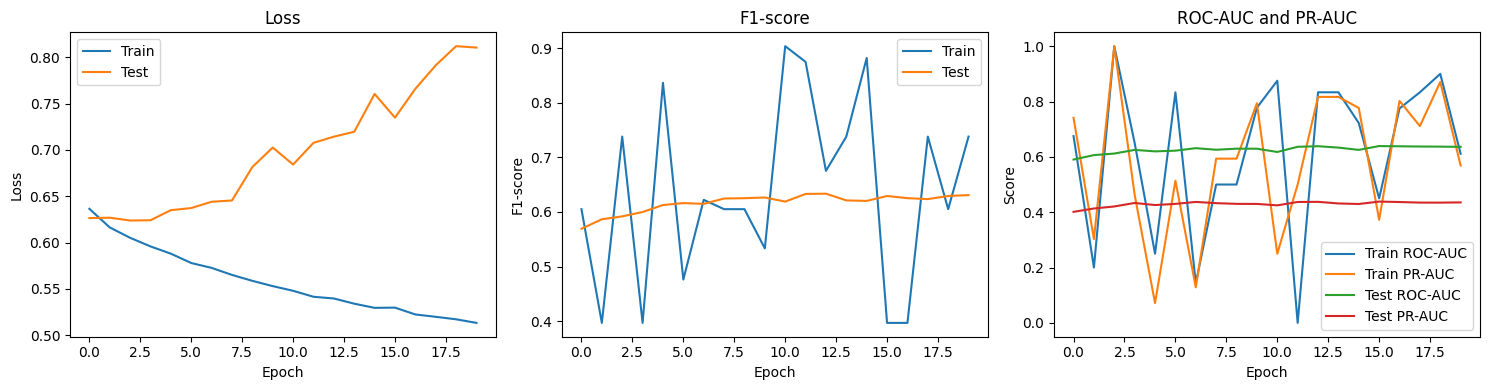

In [27]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1 
num_epochs = 20
batch_size = 64
learning_rate = 0.0001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device) 
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_19729/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_19729/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6758, Train F1-score: 0.5349, Train ROC-AUC: 0.5217, Train PR-AUC: 0.3513, Test Loss: 0.6670, Test F1-score: 0.5442, Test ROC-AUC: 0.5274, Test PR-AUC: 0.3675
Epoch [2/20], Train Loss: 0.6582, Train F1-score: 0.5371, Train ROC-AUC: 0.5304, Train PR-AUC: 0.3576, Test Loss: 0.6482, Test F1-score: 0.5517, Test ROC-AUC: 0.5287, Test PR-AUC: 0.3723
Epoch [3/20], Train Loss: 0.6416, Train F1-score: 0.5468, Train ROC-AUC: 0.5344, Train PR-AUC: 0.3674, Test Loss: 0.6364, Test F1-score: 0.5532, Test ROC-AUC: 0.5326, Test PR-AUC: 0.3742
Epoch [4/20], Train Loss: 0.6355, Train F1-score: 0.5443, Train ROC-AUC: 0.5374, Train PR-AUC: 0.3710, Test Loss: 0.6330, Test F1-score: 0.5525, Test ROC-AUC: 0.5398, Test PR-AUC: 0.3793
Epoch [5/20], Train Loss: 0.6324, Train F1-score: 0.5427, Train ROC-AUC: 0.5534, Train PR-AUC: 0.3851, Test Loss: 0.6314, Test F1-score: 0.5449, Test ROC-AUC: 0.5544, Test PR-AUC: 0.3848
Epoch [6/20], Train Loss: 0.6301, Train F1-score: 0.5417, Train R

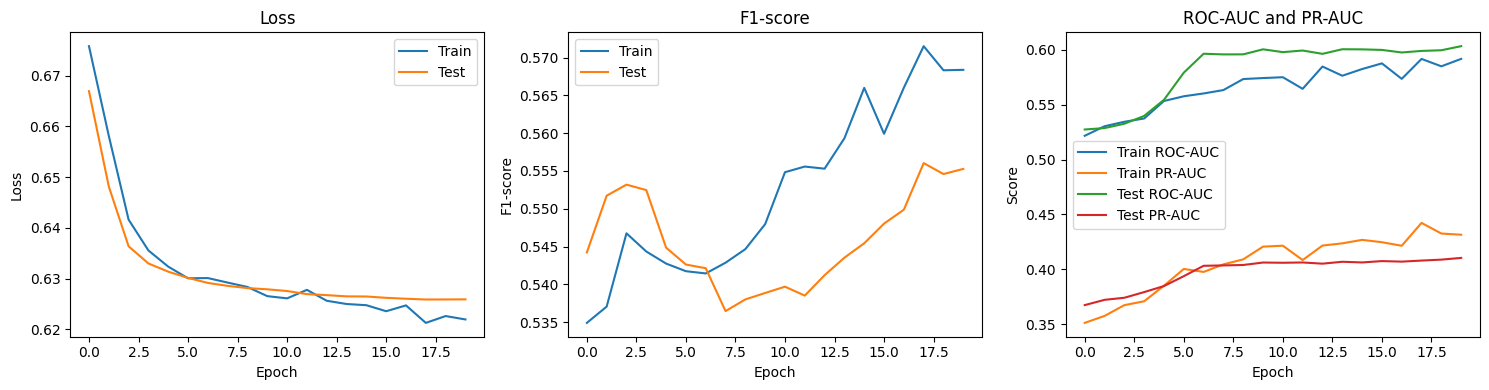

In [29]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature TFs_STAG1 importance: 0.007560137457044647
Feature Histone_H3K27me3 importance: 0.004123711340206171
Feature TFs_PAF1 importance: 0.004123711340206171
Feature TFs_PBXIP1 importance: 0.004123711340206171
Feature TFs_BRCA1 importance: 0.0027491408934707806
Feature Histone_H3K36me3 importance: 0.0020618556701030855
Feature Histone_H3K4me3 importance: 0.0020618556701030855
Feature TFs_FOSL1 importance: 0.0020618556701030855
Feature TFs_FOS importance: 0.0020618556701030855
Feature TFs_MYBL2 importance: 0.0020618556701030855
Feature Histone_H3K4me2 importance: 0.0013745704467353903
Feature TFs_CSTF2 importance: 0.0013745704467353903
Feature TFs_Epitope tags importance: 0.0013745704467353903
Feature TFs_KLF15 importance: 0.0013745704467353903
Feature Histone_H2Bub importance: 0.0006872852233676952
Feature Histone_H3K56ac importance: 0.0006872852233676952
Feature TFs_CUL4A importance: 0.0006872852233676952
Feature TFs_DDIT3 importance: 0.0006872852233676952
Feature TFs_EP300 importanc

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_19729/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_19729/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6411, Train F1-score: 0.4012, Train ROC-AUC: 0.5500, Train PR-AUC: 0.6710, Test Loss: 0.6288, Test F1-score: 0.5608, Test ROC-AUC: 0.5825, Test PR-AUC: 0.3897
Epoch [2/20], Train Loss: 0.6301, Train F1-score: 0.6806, Train ROC-AUC: 0.0000, Train PR-AUC: 0.1181, Test Loss: 0.6243, Test F1-score: 0.5589, Test ROC-AUC: 0.6047, Test PR-AUC: 0.4130
Epoch [3/20], Train Loss: 0.6281, Train F1-score: 0.5333, Train ROC-AUC: 0.6667, Train PR-AUC: 0.7639, Test Loss: 0.6239, Test F1-score: 0.5598, Test ROC-AUC: 0.6066, Test PR-AUC: 0.4159
Epoch [4/20], Train Loss: 0.6274, Train F1-score: 0.3968, Train ROC-AUC: 0.3000, Train PR-AUC: 0.3268, Test Loss: 0.6271, Test F1-score: 0.5613, Test ROC-AUC: 0.6062, Test PR-AUC: 0.4147
Epoch [5/20], Train Loss: 0.6245, Train F1-score: 0.2735, Train ROC-AUC: 0.7500, Train PR-AUC: 0.6267, Test Loss: 0.6262, Test F1-score: 0.5684, Test ROC-AUC: 0.6080, Test PR-AUC: 0.4198
Epoch [6/20], Train Loss: 0.6184, Train F1-score: 0.1667, Train R

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_19729/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_19729/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6360, Train F1-score: 0.5493, Train ROC-AUC: 0.5545, Train PR-AUC: 0.3740, Test Loss: 0.6270, Test F1-score: 0.5625, Test ROC-AUC: 0.6035, Test PR-AUC: 0.4184
Epoch [2/20], Train Loss: 0.6193, Train F1-score: 0.6017, Train ROC-AUC: 0.5984, Train PR-AUC: 0.4526, Test Loss: 0.6287, Test F1-score: 0.5787, Test ROC-AUC: 0.6017, Test PR-AUC: 0.4176
Epoch [3/20], Train Loss: 0.6097, Train F1-score: 0.6288, Train ROC-AUC: 0.6191, Train PR-AUC: 0.4813, Test Loss: 0.6283, Test F1-score: 0.5932, Test ROC-AUC: 0.6108, Test PR-AUC: 0.4287
Epoch [4/20], Train Loss: 0.6020, Train F1-score: 0.6497, Train ROC-AUC: 0.6308, Train PR-AUC: 0.5028, Test Loss: 0.6292, Test F1-score: 0.6027, Test ROC-AUC: 0.6104, Test PR-AUC: 0.4240
Epoch [5/20], Train Loss: 0.5961, Train F1-score: 0.6597, Train ROC-AUC: 0.6433, Train PR-AUC: 0.5247, Test Loss: 0.6303, Test F1-score: 0.6058, Test ROC-AUC: 0.6102, Test PR-AUC: 0.4276
Epoch [6/20], Train Loss: 0.5925, Train F1-score: 0.6680, Train R

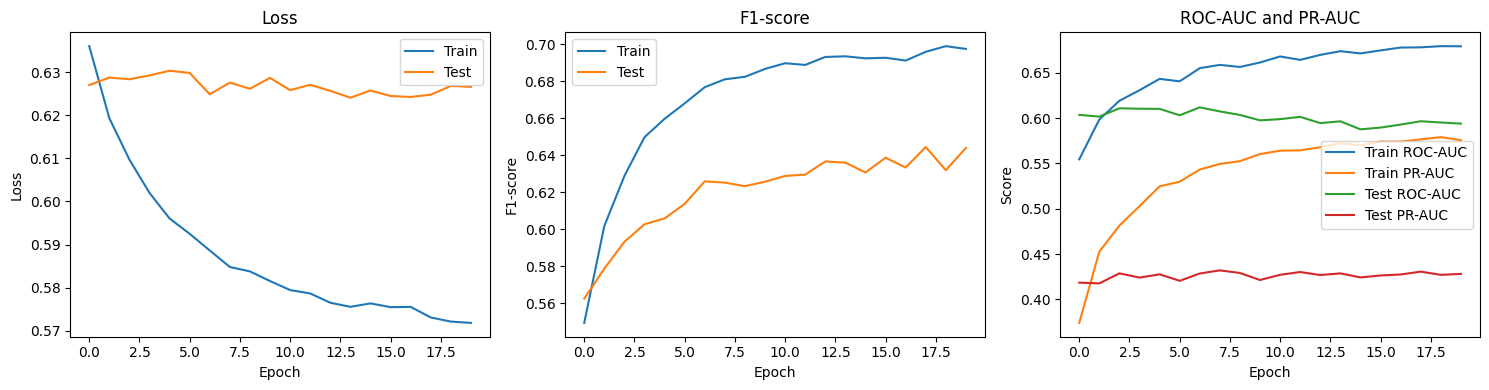

In [33]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_19729/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_19729/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6403, Train F1-score: 0.5358, Train ROC-AUC: 0.5244, Train PR-AUC: 0.3537, Test Loss: 0.6267, Test F1-score: 0.5438, Test ROC-AUC: 0.5973, Test PR-AUC: 0.4074
Epoch [2/30], Train Loss: 0.6216, Train F1-score: 0.5855, Train ROC-AUC: 0.5914, Train PR-AUC: 0.4369, Test Loss: 0.6234, Test F1-score: 0.5643, Test ROC-AUC: 0.6060, Test PR-AUC: 0.4161
Epoch [3/30], Train Loss: 0.6154, Train F1-score: 0.6033, Train ROC-AUC: 0.6082, Train PR-AUC: 0.4597, Test Loss: 0.6243, Test F1-score: 0.5854, Test ROC-AUC: 0.6037, Test PR-AUC: 0.4159
Epoch [4/30], Train Loss: 0.6106, Train F1-score: 0.6133, Train ROC-AUC: 0.6180, Train PR-AUC: 0.4735, Test Loss: 0.6252, Test F1-score: 0.5854, Test ROC-AUC: 0.6098, Test PR-AUC: 0.4200
Epoch [5/30], Train Loss: 0.6029, Train F1-score: 0.6249, Train ROC-AUC: 0.6363, Train PR-AUC: 0.4923, Test Loss: 0.6234, Test F1-score: 0.5987, Test ROC-AUC: 0.6163, Test PR-AUC: 0.4258
Epoch [6/30], Train Loss: 0.5986, Train F1-score: 0.6358, Train R

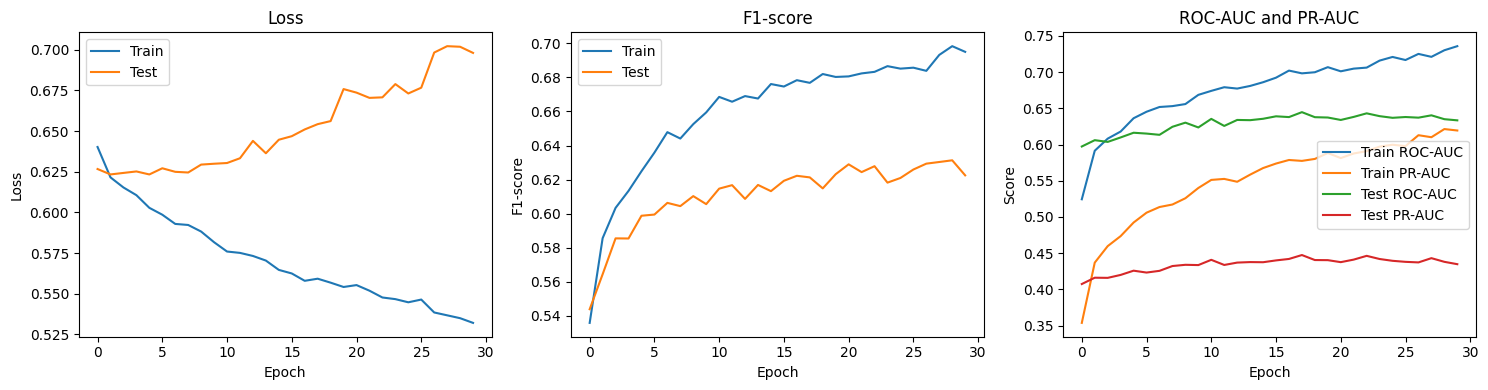

In [35]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_19729/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_19729/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|███████████████████| 364/364 [00:04<00:00, 74.76it/s]


Epoch [1/20], Train Loss: 0.6387, Train F1-score: 0.5449, Train ROC-AUC: 0.5361, Train PR-AUC: 0.3690, Test Loss: 0.6288, Test F1-score: 0.5477, Test ROC-AUC: 0.5898, Test PR-AUC: 0.3926


100%|███████████████████| 364/364 [00:04<00:00, 74.88it/s]


Epoch [2/20], Train Loss: 0.6239, Train F1-score: 0.5865, Train ROC-AUC: 0.5846, Train PR-AUC: 0.4320, Test Loss: 0.6253, Test F1-score: 0.5692, Test ROC-AUC: 0.6020, Test PR-AUC: 0.4069


100%|███████████████████| 364/364 [00:04<00:00, 74.66it/s]


Epoch [3/20], Train Loss: 0.6180, Train F1-score: 0.6027, Train ROC-AUC: 0.5923, Train PR-AUC: 0.4512, Test Loss: 0.6250, Test F1-score: 0.5748, Test ROC-AUC: 0.6053, Test PR-AUC: 0.4133


100%|███████████████████| 364/364 [00:05<00:00, 71.37it/s]


Epoch [4/20], Train Loss: 0.6093, Train F1-score: 0.6163, Train ROC-AUC: 0.6260, Train PR-AUC: 0.4816, Test Loss: 0.6487, Test F1-score: 0.5874, Test ROC-AUC: 0.6037, Test PR-AUC: 0.4135


100%|███████████████████| 364/364 [00:05<00:00, 72.59it/s]


Epoch [5/20], Train Loss: 0.6032, Train F1-score: 0.6267, Train ROC-AUC: 0.6299, Train PR-AUC: 0.4953, Test Loss: 0.6353, Test F1-score: 0.5919, Test ROC-AUC: 0.6022, Test PR-AUC: 0.4188


100%|███████████████████| 364/364 [00:04<00:00, 76.17it/s]


Epoch [6/20], Train Loss: 0.6001, Train F1-score: 0.6392, Train ROC-AUC: 0.6366, Train PR-AUC: 0.5003, Test Loss: 0.6285, Test F1-score: 0.6032, Test ROC-AUC: 0.6232, Test PR-AUC: 0.4346


100%|███████████████████| 364/364 [00:04<00:00, 76.07it/s]


Epoch [7/20], Train Loss: 0.5956, Train F1-score: 0.6442, Train ROC-AUC: 0.6457, Train PR-AUC: 0.5054, Test Loss: 0.6320, Test F1-score: 0.6051, Test ROC-AUC: 0.6096, Test PR-AUC: 0.4224


100%|███████████████████| 364/364 [00:04<00:00, 75.66it/s]


Epoch [8/20], Train Loss: 0.5867, Train F1-score: 0.6487, Train ROC-AUC: 0.6593, Train PR-AUC: 0.5275, Test Loss: 0.6310, Test F1-score: 0.6077, Test ROC-AUC: 0.6215, Test PR-AUC: 0.4307


100%|███████████████████| 364/364 [00:04<00:00, 75.48it/s]


Epoch [9/20], Train Loss: 0.5830, Train F1-score: 0.6617, Train ROC-AUC: 0.6596, Train PR-AUC: 0.5358, Test Loss: 0.6495, Test F1-score: 0.6107, Test ROC-AUC: 0.6187, Test PR-AUC: 0.4290


100%|███████████████████| 364/364 [00:04<00:00, 74.62it/s]


Epoch [10/20], Train Loss: 0.5787, Train F1-score: 0.6558, Train ROC-AUC: 0.6716, Train PR-AUC: 0.5428, Test Loss: 0.6537, Test F1-score: 0.6064, Test ROC-AUC: 0.6158, Test PR-AUC: 0.4211


100%|███████████████████| 364/364 [00:05<00:00, 70.52it/s]


Epoch [11/20], Train Loss: 0.5756, Train F1-score: 0.6614, Train ROC-AUC: 0.6711, Train PR-AUC: 0.5472, Test Loss: 0.6477, Test F1-score: 0.6159, Test ROC-AUC: 0.6318, Test PR-AUC: 0.4340


100%|███████████████████| 364/364 [00:05<00:00, 68.86it/s]


Epoch [12/20], Train Loss: 0.5674, Train F1-score: 0.6717, Train ROC-AUC: 0.6859, Train PR-AUC: 0.5682, Test Loss: 0.6688, Test F1-score: 0.6287, Test ROC-AUC: 0.6259, Test PR-AUC: 0.4296


100%|███████████████████| 364/364 [00:05<00:00, 69.62it/s]


Epoch [13/20], Train Loss: 0.5675, Train F1-score: 0.6673, Train ROC-AUC: 0.6773, Train PR-AUC: 0.5556, Test Loss: 0.6892, Test F1-score: 0.6120, Test ROC-AUC: 0.6175, Test PR-AUC: 0.4198


100%|███████████████████| 364/364 [00:05<00:00, 70.41it/s]


Epoch [14/20], Train Loss: 0.5672, Train F1-score: 0.6694, Train ROC-AUC: 0.6890, Train PR-AUC: 0.5657, Test Loss: 0.6642, Test F1-score: 0.6197, Test ROC-AUC: 0.6245, Test PR-AUC: 0.4276


100%|███████████████████| 364/364 [00:05<00:00, 70.12it/s]


Epoch [15/20], Train Loss: 0.5625, Train F1-score: 0.6728, Train ROC-AUC: 0.6907, Train PR-AUC: 0.5724, Test Loss: 0.6508, Test F1-score: 0.6194, Test ROC-AUC: 0.6182, Test PR-AUC: 0.4193


100%|███████████████████| 364/364 [00:05<00:00, 71.31it/s]


Epoch [16/20], Train Loss: 0.5593, Train F1-score: 0.6740, Train ROC-AUC: 0.6913, Train PR-AUC: 0.5736, Test Loss: 0.6731, Test F1-score: 0.6151, Test ROC-AUC: 0.6124, Test PR-AUC: 0.4192


100%|███████████████████| 364/364 [00:05<00:00, 72.00it/s]


Epoch [17/20], Train Loss: 0.5566, Train F1-score: 0.6797, Train ROC-AUC: 0.6986, Train PR-AUC: 0.5775, Test Loss: 0.6756, Test F1-score: 0.6220, Test ROC-AUC: 0.6094, Test PR-AUC: 0.4169


100%|███████████████████| 364/364 [00:05<00:00, 70.76it/s]


Epoch [18/20], Train Loss: 0.5552, Train F1-score: 0.6791, Train ROC-AUC: 0.6993, Train PR-AUC: 0.5811, Test Loss: 0.7034, Test F1-score: 0.6205, Test ROC-AUC: 0.6172, Test PR-AUC: 0.4196


100%|███████████████████| 364/364 [00:05<00:00, 70.25it/s]


Epoch [19/20], Train Loss: 0.5477, Train F1-score: 0.6830, Train ROC-AUC: 0.7051, Train PR-AUC: 0.5902, Test Loss: 0.7151, Test F1-score: 0.6253, Test ROC-AUC: 0.6228, Test PR-AUC: 0.4227


100%|███████████████████| 364/364 [00:05<00:00, 69.29it/s]


Epoch [20/20], Train Loss: 0.5475, Train F1-score: 0.6846, Train ROC-AUC: 0.7029, Train PR-AUC: 0.5882, Test Loss: 0.7136, Test F1-score: 0.6350, Test ROC-AUC: 0.6229, Test PR-AUC: 0.4233


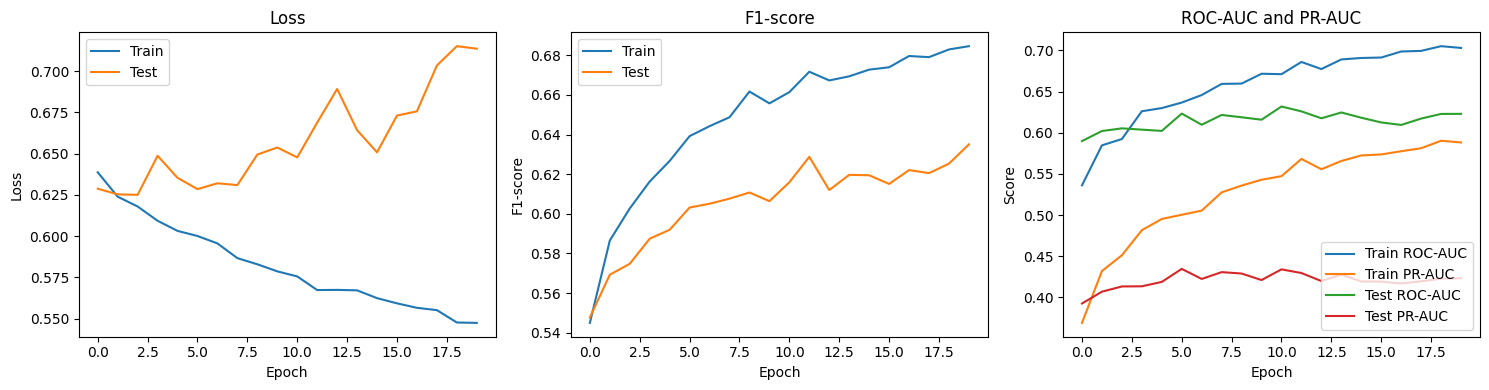

In [37]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2


model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):

    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))

    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.7085, Train F1-score: 0.3514, Train ROC-AUC: 0.5232, Train PR-AUC: 0.3633, Test Loss: 0.6987, Test F1-score: 0.3303, Test ROC-AUC: 0.5321, Test PR-AUC: 0.3566
Epoch [2/50], Train Loss: 0.6972, Train F1-score: 0.5857, Train ROC-AUC: 0.5338, Train PR-AUC: 0.3715, Test Loss: 0.6887, Test F1-score: 0.5813, Test ROC-AUC: 0.5336, Test PR-AUC: 0.3639
Epoch [3/50], Train Loss: 0.6876, Train F1-score: 0.5790, Train ROC-AUC: 0.5418, Train PR-AUC: 0.3803, Test Loss: 0.6799, Test F1-score: 0.5704, Test ROC-AUC: 0.5352, Test PR-AUC: 0.3721
Epoch [4/50], Train Loss: 0.6790, Train F1-score: 0.5639, Train ROC-AUC: 0.5462, Train PR-AUC: 0.3889, Test Loss: 0.6722, Test F1-score: 0.5585, Test ROC-AUC: 0.5307, Test PR-AUC: 0.3725
Epoch [5/50], Train Loss: 0.6719, Train F1-score: 0.5540, Train ROC-AUC: 0.5497, Train PR-AUC: 0.3926, Test Loss: 0.6657, Test F1-score: 0.5513, Test ROC-AUC: 0.5369, Test PR-AUC: 0.3769
Epoch [6/50], Train Loss: 0.6643, Train F1-score: 0.5529, Train R

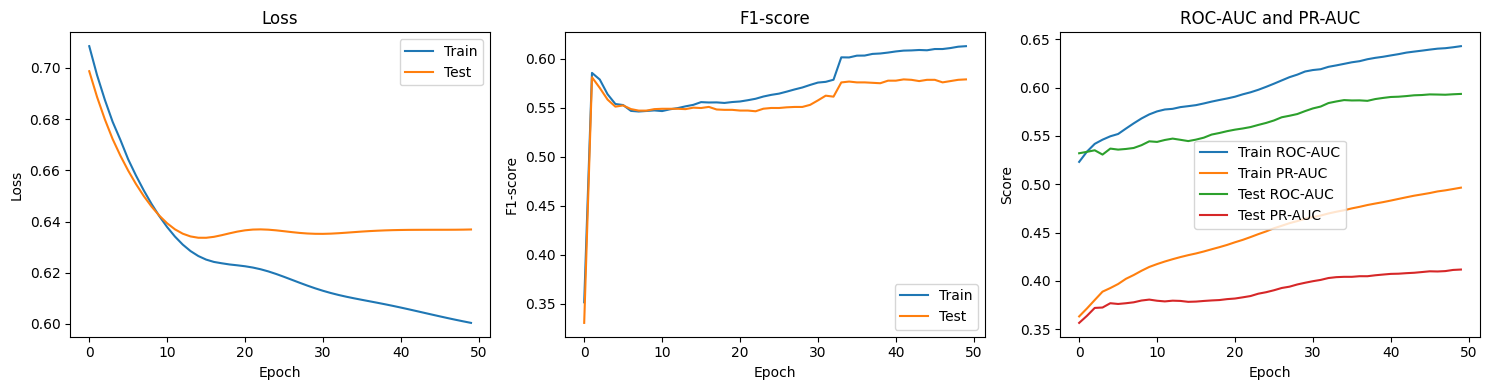

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [40]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [41]:
df_x

,Histone_H3K36me3,Histone_H4K20me3,Histone_H3K36me2,Histone_H3R2me2,Histone_H2B,Histone_H4K20me1,Histone_H3K27ac,Histone_H2A.X,Histone_H3K9me3,Histone_H3K9me2,...,TFs_TP53,TFs_TP73,TFs_TRIM28,TFs_TUBG1,TFs_VRK1,TFs_WDR5,TFs_ZBTB17,TFs_ZBTB48,TFs_ZMYND11,TFs_ZNF768
0,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.451394,-0.036799,-0.223672,-0.026575,...,-0.150521,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,-0.081067
1,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.451394,-0.036799,-0.223672,-0.026575,...,-0.150521,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,1.589036
2,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.451394,-0.036799,-0.223672,-0.026575,...,-0.150521,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,-0.081067
3,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.451394,-0.036799,-0.223672,-0.026575,...,-0.150521,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,-0.081067
4,-0.15142,4.577652,-0.062824,-0.042897,-0.018657,-0.038877,2.168600,-0.036799,0.402760,-0.026575,...,0.409274,-0.132406,3.069802,-0.012767,-0.025382,-0.067019,1.159812,2.058792,-0.026132,-0.081067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.189002,-0.036799,-0.223672,-0.026575,...,0.338769,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,1.580900,-0.122471,-0.026132,-0.081067
7268,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.451394,-0.036799,-0.223672,-0.026575,...,-0.150521,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,-0.081067
7269,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,0.009798,-0.036799,-0.223672,-0.026575,...,-0.150521,-0.132406,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,-0.081067
7270,-0.15142,-0.034388,-0.062824,-0.042897,-0.018657,-0.038877,-0.291390,-0.036799,-0.223672,-0.026575,...,-0.150521,0.149759,-0.143638,-0.012767,-0.025382,-0.067019,-0.082842,-0.122471,-0.026132,-0.081067


In [42]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [43]:
df_y

,target
0,0
1,0
2,0
3,1
4,1
...,...
7267,1
7268,1
7269,0
7270,1


In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_19729/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.02784022412219074
Histone_H4K20me3: 0.00011146467760949334
Histone_H3K36me2: 0.0018199449334086006
Histone_H3R2me2: 0.0005454226997090855
Histone_H2B: 1.0346885320111265e-05
Histone_H4K20me1: 0.000304131544040945
Histone_H3K27ac: 0.07910603979544589
Histone_H2A.X: 0.0009489864607608549
Histone_H3K9me3: 0.019301558270904188
Histone_H3K9me2: 7.762257162361206e-06
Histone_H2A.Z: 0.011999069335802068
Histone_H3K18ac: 0.008635705660208019
Histone_H3: 2.1204714346433093e-05
Histone_H4: 1.6979323149824714e-05
Histone_H3K79me2: 0.0051551743008352935
Histone_H3S57ph: 6.101464212393772e-06
Histone_H2AT120ph: 4.363292911240073e-06
Histone_H2Bub: 2.2062590217762627e-05
Histone_H2A.XS139ph: 0.00012570326785248126
Histone_H3K9ac: 0.013395216887744803
Histone_H3K4me2: 0.028224138817634015
Histone_H3K4me3: 0.02552757358842253
Histone_H3K27me3: 0.024476094047379673
Histone_H3K56ac: 0.017649099731219805
Histone_H3K4me1: 0.0906069767989187
Histone_H4K16ac: 0.0
Histone_H2AK120Ub: 0.000

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_19729/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.3899
ROC-AUC: 0.5720
PR-AUC: 0.5108


              feature  importance
24    Histone_H3K4me1    0.091168
6     Histone_H3K27ac    0.079751
64   TFs_Epitope tags    0.074640
73           TFs_FLI1    0.040562
53           TFs_CTCF    0.036819
..                ...         ...
118         TFs_SIRT3    0.000000
88           TFs_JUND    0.000000
90           TFs_MCM5    0.000000
110         TFs_RAD51    0.000000
82   TFs_G-quadruplex    0.000000

[144 rows x 2 columns]


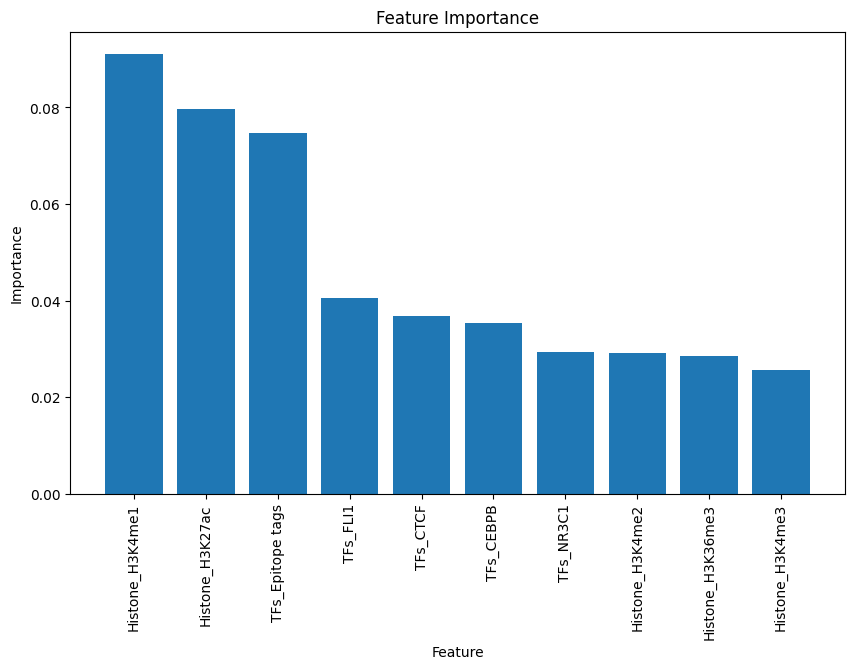

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [47]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6792576	total: 52.7ms	remaining: 52.6s
1:	learn: 0.6686869	total: 55.8ms	remaining: 27.8s
2:	learn: 0.6601494	total: 58.6ms	remaining: 19.5s
3:	learn: 0.6531560	total: 61ms	remaining: 15.2s
4:	learn: 0.6472987	total: 63.4ms	remaining: 12.6s
5:	learn: 0.6424988	total: 66ms	remaining: 10.9s
6:	learn: 0.6377146	total: 69ms	remaining: 9.79s
7:	learn: 0.6337380	total: 72ms	remaining: 8.92s
8:	learn: 0.6311766	total: 74.5ms	remaining: 8.21s
9:	learn: 0.6288362	total: 77.3ms	remaining: 7.65s
10:	learn: 0.6251394	total: 79.9ms	remaining: 7.18s
11:	learn: 0.6232565	total: 82.6ms	remaining: 6.8s
12:	learn: 0.6220596	total: 85.3ms	remaining: 6.47s
13:	learn: 0.6201109	total: 87.9ms	remaining: 6.19s
14:	learn: 0.6184715	total: 90.7ms	remaining: 5.96s
15:	learn: 0.6172609	total: 93.4ms	remaining: 5.75s
16:	learn: 0.6160758	total: 95.8ms	remaining: 5.54s
17:	learn: 0.6145360	total: 98.5ms	remaining: 5.38s
18:	learn: 0.6136677	total: 101ms	remaining: 5.24s
19:	learn: 0.6124518	total: 104m

212:	learn: 0.5012124	total: 639ms	remaining: 2.36s
213:	learn: 0.5007932	total: 642ms	remaining: 2.36s
214:	learn: 0.5005873	total: 644ms	remaining: 2.35s
215:	learn: 0.5001376	total: 647ms	remaining: 2.35s
216:	learn: 0.4997857	total: 650ms	remaining: 2.35s
217:	learn: 0.4991032	total: 653ms	remaining: 2.34s
218:	learn: 0.4987646	total: 656ms	remaining: 2.34s
219:	learn: 0.4983420	total: 659ms	remaining: 2.33s
220:	learn: 0.4977595	total: 662ms	remaining: 2.33s
221:	learn: 0.4972241	total: 664ms	remaining: 2.33s
222:	learn: 0.4966961	total: 667ms	remaining: 2.32s
223:	learn: 0.4963357	total: 670ms	remaining: 2.32s
224:	learn: 0.4958729	total: 673ms	remaining: 2.32s
225:	learn: 0.4956265	total: 676ms	remaining: 2.31s
226:	learn: 0.4955256	total: 679ms	remaining: 2.31s
227:	learn: 0.4951768	total: 682ms	remaining: 2.31s
228:	learn: 0.4948023	total: 685ms	remaining: 2.31s
229:	learn: 0.4944952	total: 688ms	remaining: 2.3s
230:	learn: 0.4942342	total: 691ms	remaining: 2.3s
231:	learn: 0.

412:	learn: 0.4403560	total: 1.22s	remaining: 1.74s
413:	learn: 0.4400813	total: 1.23s	remaining: 1.73s
414:	learn: 0.4398252	total: 1.23s	remaining: 1.73s
415:	learn: 0.4395010	total: 1.23s	remaining: 1.73s
416:	learn: 0.4391767	total: 1.23s	remaining: 1.72s
417:	learn: 0.4386656	total: 1.24s	remaining: 1.72s
418:	learn: 0.4384901	total: 1.24s	remaining: 1.72s
419:	learn: 0.4382100	total: 1.24s	remaining: 1.72s
420:	learn: 0.4379768	total: 1.25s	remaining: 1.71s
421:	learn: 0.4377873	total: 1.25s	remaining: 1.71s
422:	learn: 0.4374275	total: 1.25s	remaining: 1.71s
423:	learn: 0.4371919	total: 1.25s	remaining: 1.7s
424:	learn: 0.4369921	total: 1.26s	remaining: 1.7s
425:	learn: 0.4366283	total: 1.26s	remaining: 1.7s
426:	learn: 0.4363210	total: 1.26s	remaining: 1.69s
427:	learn: 0.4359181	total: 1.26s	remaining: 1.69s
428:	learn: 0.4357862	total: 1.27s	remaining: 1.69s
429:	learn: 0.4356176	total: 1.27s	remaining: 1.69s
430:	learn: 0.4354137	total: 1.27s	remaining: 1.68s
431:	learn: 0.4

615:	learn: 0.4013629	total: 1.81s	remaining: 1.13s
616:	learn: 0.4012271	total: 1.81s	remaining: 1.12s
617:	learn: 0.4008107	total: 1.81s	remaining: 1.12s
618:	learn: 0.4006270	total: 1.81s	remaining: 1.12s
619:	learn: 0.4004211	total: 1.82s	remaining: 1.11s
620:	learn: 0.4003079	total: 1.82s	remaining: 1.11s
621:	learn: 0.4001479	total: 1.82s	remaining: 1.11s
622:	learn: 0.3999976	total: 1.83s	remaining: 1.1s
623:	learn: 0.3999071	total: 1.83s	remaining: 1.1s
624:	learn: 0.3996617	total: 1.83s	remaining: 1.1s
625:	learn: 0.3994806	total: 1.83s	remaining: 1.1s
626:	learn: 0.3994239	total: 1.84s	remaining: 1.09s
627:	learn: 0.3991140	total: 1.84s	remaining: 1.09s
628:	learn: 0.3989948	total: 1.84s	remaining: 1.09s
629:	learn: 0.3987352	total: 1.85s	remaining: 1.08s
630:	learn: 0.3984838	total: 1.85s	remaining: 1.08s
631:	learn: 0.3983970	total: 1.85s	remaining: 1.08s
632:	learn: 0.3981267	total: 1.85s	remaining: 1.07s
633:	learn: 0.3979732	total: 1.86s	remaining: 1.07s
634:	learn: 0.39

821:	learn: 0.3717252	total: 2.39s	remaining: 518ms
822:	learn: 0.3715879	total: 2.4s	remaining: 515ms
823:	learn: 0.3715628	total: 2.4s	remaining: 512ms
824:	learn: 0.3715536	total: 2.4s	remaining: 509ms
825:	learn: 0.3714271	total: 2.4s	remaining: 506ms
826:	learn: 0.3713396	total: 2.41s	remaining: 503ms
827:	learn: 0.3712826	total: 2.41s	remaining: 500ms
828:	learn: 0.3712397	total: 2.41s	remaining: 497ms
829:	learn: 0.3712046	total: 2.41s	remaining: 495ms
830:	learn: 0.3711055	total: 2.42s	remaining: 492ms
831:	learn: 0.3710364	total: 2.42s	remaining: 489ms
832:	learn: 0.3710020	total: 2.42s	remaining: 486ms
833:	learn: 0.3708888	total: 2.43s	remaining: 483ms
834:	learn: 0.3707775	total: 2.43s	remaining: 480ms
835:	learn: 0.3706564	total: 2.43s	remaining: 477ms
836:	learn: 0.3706147	total: 2.43s	remaining: 474ms
837:	learn: 0.3705555	total: 2.44s	remaining: 471ms
838:	learn: 0.3704006	total: 2.44s	remaining: 468ms
839:	learn: 0.3703090	total: 2.44s	remaining: 465ms
840:	learn: 0.37

In [48]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 2.349001642459583
Histone_H4K20me3: 0.004316832668953827
Histone_H3K36me2: 0.12166340701735863
Histone_H3R2me2: 0.012398044957575755
Histone_H2B: 0.00035115218260731726
Histone_H4K20me1: 0.0
Histone_H3K27ac: 8.406190597907841
Histone_H2A.X: 0.1120413329918611
Histone_H3K9me3: 1.90933816603572
Histone_H3K9me2: 0.0017565551365385037
Histone_H2A.Z: 1.2054061664754971
Histone_H3K18ac: 1.1096951879558783
Histone_H3: 0.0011006628577567156
Histone_H4: 0.0023228067239351394
Histone_H3K79me2: 0.7749494049179518
Histone_H3S57ph: 0.003193359121466885
Histone_H2AT120ph: 0.004238841979575856
Histone_H2Bub: 0.0016102389535557428
Histone_H2A.XS139ph: 0.00834262494701618
Histone_H3K9ac: 1.2228189512735246
Histone_H3K4me2: 3.3039491033349706
Histone_H3K4me3: 3.5485950123202823
Histone_H3K27me3: 1.9592887846370282
Histone_H3K56ac: 2.0922925033115654
Histone_H3K4me1: 8.626639080419585
Histone_H4K16ac: 0.0
Histone_H2AK120Ub: 0.0027846708127555304
Histone_H1.4: 1.128288475901691
Histone_H

              feature  importance
24    Histone_H3K4me1    8.626639
6     Histone_H3K27ac    8.406191
64   TFs_Epitope tags    6.866290
73           TFs_FLI1    4.232087
44          TFs_CEBPB    3.858909
..                ...         ...
80           TFs_GLI1    0.000000
25    Histone_H4K16ac    0.000000
81           TFs_GLI2    0.000000
82   TFs_G-quadruplex    0.000000
111           TFs_RB1    0.000000

[144 rows x 2 columns]


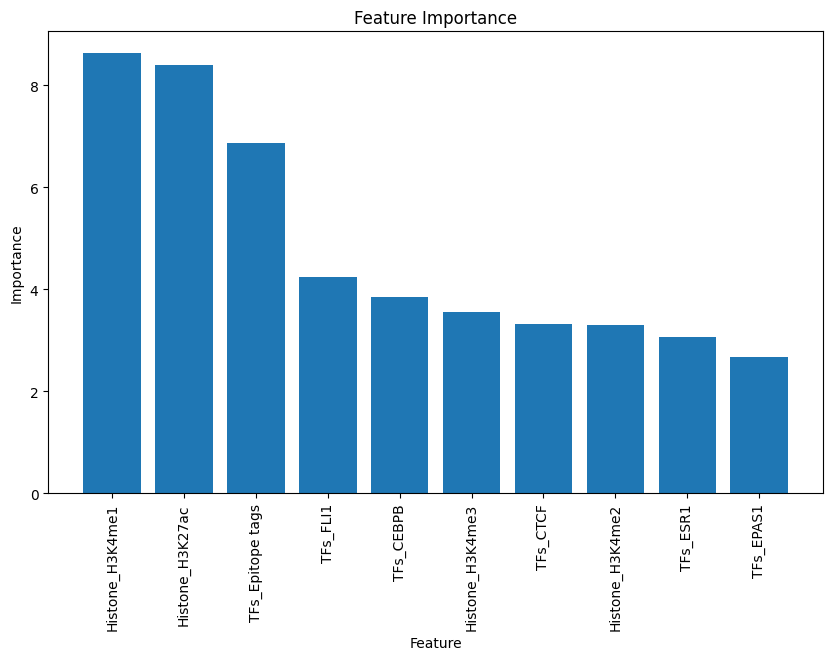

In [49]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
